## This Book Conducts Semantic Analysis on speaker using cosine similarity 

In [103]:
#import libraries
#reading api key
from dotenv import dotenv_values
#reading data 
import pandas as pd
#data preprocessing
import re
import numpy as np
from transformers import BertModel, BertTokenizer 
import textwrap
#vector embedding 
import torch
#clustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
#topic generation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from openai import OpenAI
import networkx as nx


In [89]:
#import openai credentials 
config = dotenv_values('credential.env')
openai_key = config['openai_api_key']
openai_deployment_name = "gpt-4"


In [21]:
df = pd.read_csv('csv/Meeting_5_Session_3.csv')
df.head()

,Id,Session,Meeting,Speaker,Text
0,S3M51,3,5,Chairman,"Good morning, distinguished delegates. Please ..."
1,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...
2,S3M53,3,5,Chairman,I thank the distinguished representative of th...
3,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside..."
4,S3M55,3,5,Chairman,I thank the distinguished representative of Ne...


In [22]:
#remove all rows with "Chairman" in the speaker column and store in a new df
df_updated = df[df['Speaker'] != 'Chairman']
#get the number of rows
print(f' number of rows is {df_updated.shape[0]}')

 number of rows is 37


In [23]:
def chunk_text(row):
    text = row['Text']
    if len(text) > 3500:
        return textwrap.wrap(text, 3500)
    else:
        return [text]



In [24]:
#data cleaning 
def updated_text(text):
    #merge hyphanated words
    text = text.replace(' - ', '')
    #delete hyphens
    text = text.replace('-', '')
    #merge all words that have anti preceeding it with anti
    text  = re.sub(r'anti (\w+)', r'anti\1', text)
    text = text.replace('.', ' .')
    text = text.replace(',', ' ,')
    return text

In [25]:
# remove stop words from a custom list of stop words
stopwords = ['the', 'a', 'an', 'and', 'but', 'if', 'or', 'because', 'as', 
             'what', 'which', 'this', 'that', 'these', 'those', 'then', 
             'just', 'so', 'than', 'such', 'both', 'through', 'about', 
             'for', 'is', 'of', 'while', 'during', 'to', 'What', 'Which', 
             'Is', 'If', 'While', 'This', 'we','mr.', 'mr','chairman','chair', 'chairperson','thank', 'you','chairman.']

def remove_stopwords(text):
    #convert to lowercase
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stopwords)
    return text


In [26]:
df_updated['Text'] = df_updated.apply(chunk_text, axis=1)
df_updated = df_updated.explode('Text').reset_index(drop=True)
df_updated['cleaned_text'] = df_updated['Text'].apply(updated_text)
df_updated['cleaned_text'] = df_updated['cleaned_text'].apply(remove_stopwords)
df_updated.head()

/var/folders/5r/2zxjpss509zbfp38213y6wv00000gn/T/ipykernel_99398/4252244400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_updated['Text'] = df_updated.apply(chunk_text, axis=1)


,Id,Session,Meeting,Speaker,Text,cleaned_text
0,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...,. . would like take floor on sub items on topi...
1,S3M52,3,5,Russia,connection with the adoption of their obligati...,connection with adoption their obligations tak...
2,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside...",", . , when new zealand considers responsible b..."
3,S3M56,3,5,Italy,"Thank you, Mr. Chair. As we said many times be...",", . . said many times before , current strateg..."
4,S3M58,3,5,China,"Thank you, Mr. Chairman. China believes that d...",", . . china believes discussing capabilities a..."


In [27]:
max_length_df = df['Text'].str.len().max()
max_length_df

10278

In [28]:
max_length = df_updated['cleaned_text'].str.len().max()
max_length

2986

In [32]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'  
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [33]:
# Function to generate contextual embeddings
def generate_contextual_embedding(text):
    # Tokenize input text
    input_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors='pt')
    # Generate contextual embeddings
    with torch.no_grad():
        outputs = model(input_ids)
        # Extract contextual embeddings from the last layer
        last_hidden_states = outputs.last_hidden_state
    # Average pooling over tokens to get a single vector representation
    contextual_embedding = torch.mean(last_hidden_states, dim=1).squeeze().numpy()
    return contextual_embedding


In [34]:
# Compute contextual embeddings for each document
df_updated['contextual_embedding'] = df_updated['cleaned_text'].apply(generate_contextual_embedding)


In [36]:
df_updated.head()

,Id,Session,Meeting,Speaker,Text,cleaned_text,contextual_embedding
0,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...,. . would like take floor on sub items on topi...,"[-0.35218367, 0.17405602, 0.44900993, -0.10542..."
1,S3M52,3,5,Russia,connection with the adoption of their obligati...,connection with adoption their obligations tak...,"[-0.30835244, 0.061460797, 0.24975899, -0.1546..."
2,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside...",", . , when new zealand considers responsible b...","[-0.21464926, 0.27779922, 0.41761667, 0.010075..."
3,S3M56,3,5,Italy,"Thank you, Mr. Chair. As we said many times be...",", . . said many times before , current strateg...","[-0.15198769, 0.223905, 0.5595103, 0.004948167..."
4,S3M58,3,5,China,"Thank you, Mr. Chairman. China believes that d...",", . . china believes discussing capabilities a...","[-0.39602536, 0.17177016, 0.42725387, 0.078603..."


In [40]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    cosine_similarity = dot_product / (norm_vector1 * norm_vector2)
    return cosine_similarity


In [41]:
# Compute cosine similarity matrix
contextual_embeddings = np.stack(df_updated['contextual_embedding'].to_numpy())
cosine_sim_matrix = np.array([[cosine_similarity(embedding1, embedding2) for embedding2 in contextual_embeddings] for embedding1 in contextual_embeddings])


In [42]:
# Perform Spectral Clustering
n_clusters = 5
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
cluster_labels = spectral_clustering.fit_predict(cosine_sim_matrix)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [43]:
# Add cluster labels to the original DataFrame
df_updated['cluster_label'] = cluster_labels
df_updated.head()

,Id,Session,Meeting,Speaker,Text,cleaned_text,contextual_embedding,cluster_label
0,S3M52,3,5,Russia,Mr. Chairman. We would like to take the floor ...,. . would like take floor on sub items on topi...,"[-0.35218367, 0.17405602, 0.44900993, -0.10542...",1
1,S3M52,3,5,Russia,connection with the adoption of their obligati...,connection with adoption their obligations tak...,"[-0.30835244, 0.061460797, 0.24975899, -0.1546...",0
2,S3M54,3,5,New Zealand,"Thank you, Mr. Chair, when New Zealand conside...",", . , when new zealand considers responsible b...","[-0.21464926, 0.27779922, 0.41761667, 0.010075...",1
3,S3M56,3,5,Italy,"Thank you, Mr. Chair. As we said many times be...",", . . said many times before , current strateg...","[-0.15198769, 0.223905, 0.5595103, 0.004948167...",1
4,S3M58,3,5,China,"Thank you, Mr. Chairman. China believes that d...",", . . china believes discussing capabilities a...","[-0.39602536, 0.17177016, 0.42725387, 0.078603...",4


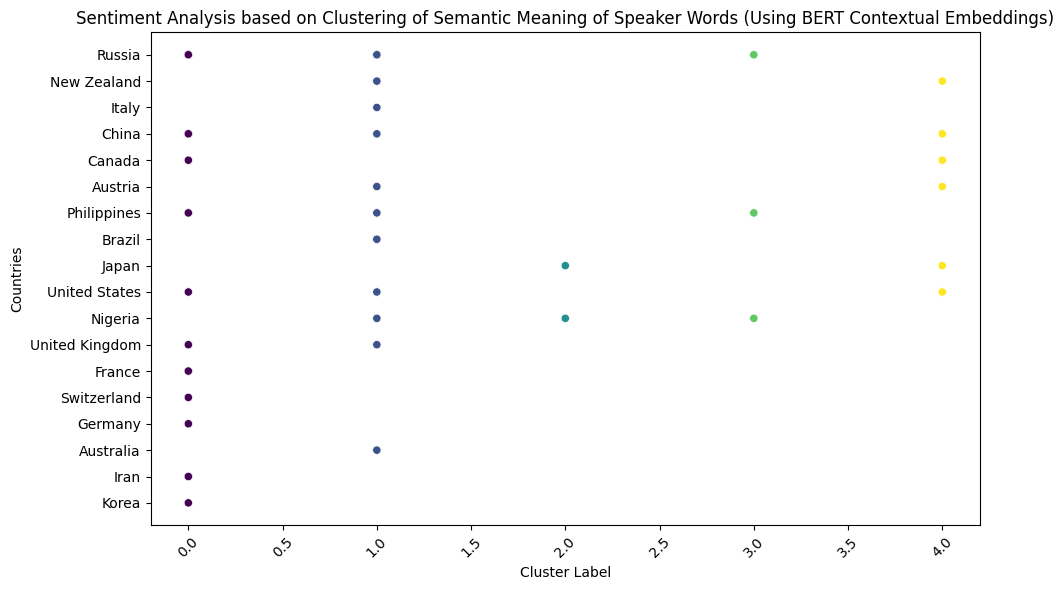

In [45]:
# Visualize the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_updated, x='cluster_label', y='Speaker', hue='cluster_label', palette='viridis', legend=False)
plt.title('Sentiment Analysis based on Clustering of Semantic Meaning of Speaker Words (Using BERT Contextual Embeddings)')
plt.xticks(rotation=45)
plt.xlabel('Cluster Label')
plt.ylabel('Countries')
plt.tight_layout()
plt.show()

In [59]:
# Function to conduct topic modeling on a cluster
def conduct_topic_modeling(cluster_data):
    # Extract text data for the cluster
    cluster_text = cluster_data['cleaned_text'].values
    
    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(cluster_text)
    
    # Apply Non-negative Matrix Factorization (NMF) for topic modeling
    nmf = NMF(n_components=2, random_state=42)
    W = nmf.fit_transform(X)
    
    # Get the feature names (words from vocabulary)
    feature_names = vectorizer.get_feature_names_out()
    
    # Print the top words for each topic
    topics = []
    for topic_idx, topic in enumerate(nmf.components_):
        top_words_idx = topic.argsort()[::-1][:10]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
    return topics

In [90]:
client = OpenAI(api_key=openai_key)


def prompt_engineering(topics):
    chat_context_prompt = f"With the words provided, what is the topic of discussion {topics}"
    return chat_context_prompt

def topic_generation(topics):
    chat_context_prompt = prompt_engineering(topics)
    MESSAGES = [
        {"role": "system", "content": chat_context_prompt},
        {"role": "user", "content": ""}
    ]

    completion = client.chat.completions.create(
        model=openai_deployment_name,
        messages=MESSAGES,
        temperature=0.6,
        max_tokens=200
    )
    
    return completion.choices[0].message.content


In [105]:
# Iterate over each cluster
for cluster_id in range(n_clusters):
    print(f"Cluster {cluster_id}:")
    # Get unique countries in the cluster
    unique_countries = cluster_data['Speaker'].unique()
    print("Countries:", ", ".join(unique_countries))
    cluster_data = df_updated[df_updated['cluster_label'] == cluster_id]
    topics = conduct_topic_modeling(cluster_data)
    print("Topics:", topics)
    print(topic_generation(topics))


Cluster 0:
Countries: China, Canada, Austria, United States, Japan, New Zealand
Topics: [['space', 'operations', 'state', 'military', 'proximity', 'rendezvous', 'object', 'objects', 'security', 'like'], ['issue', 'legal', 'work', 'responsible', 'space', 'states', 'group', 'canadian', 'use', 'activities']]
The topic of discussion is likely about space security, military operations in space and legal issues related to space activities.
Cluster 1:
Countries: Russia, China, Philippines, Canada, France, Switzerland, Germany, Iran, Korea, United States, United Kingdom
Topics: [['space', 'use', 'states', 'outer', 'capabilities', 'systems', 'objects', 'norms', 'activities', 'weapons'], ['regards', 'copiers', 'staff', 'safety', 'issue', 'unfriendly', 'duplicating', 'left', 'wg', 'leave']]
1) Space weapons and outer space activities
2) Safety issues regarding the use of copiers in a workplace
Cluster 2:
Countries: Russia, New Zealand, Italy, Austria, Philippines, Brazil, United Kingdom, China, N

In [102]:
#save the df_updated into a csv file in the csv folder
df_updated.to_csv('Sentiment_analysis/Meeting_5_Session_3_sentiment_analysis.csv', index=False)

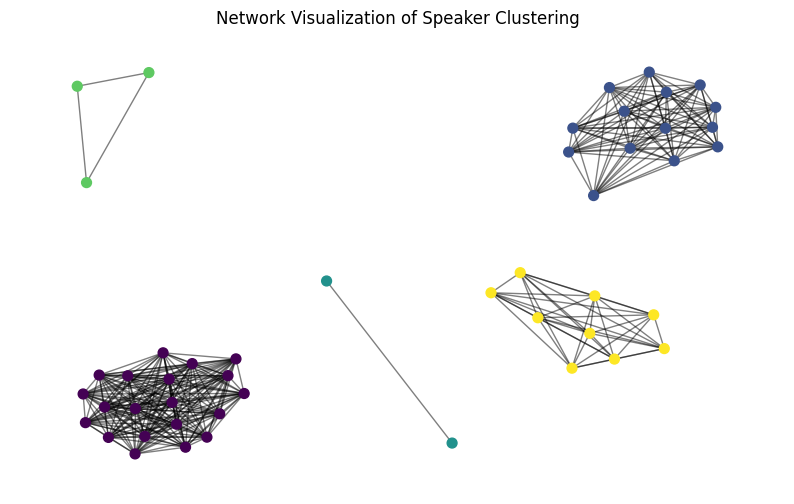

In [104]:
# Create a network graph
G = nx.Graph()

# Add nodes for each document with cluster label as node attribute
for index, row in df_updated.iterrows():
    G.add_node(index, cluster_label=row['cluster_label'])

# Add edges between documents belonging to the same cluster
for cluster_id in range(n_clusters):
    cluster_data = df_updated[df_updated['cluster_label'] == cluster_id]
    for i, row1 in cluster_data.iterrows():
        for j, row2 in cluster_data.iterrows():
            if i != j:
                G.add_edge(i, j)

# Draw the network graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=0.64) 
nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.viridis, node_color=cluster_labels)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Network Visualization of Speaker Clustering')
plt.axis('off')
plt.show()